# INF250 - Assignment 2

In [47]:
import skimage
from skimage import io, color, filters, feature, measure, morphology, segmentation
from skimage.morphology import area_closing, area_opening
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt

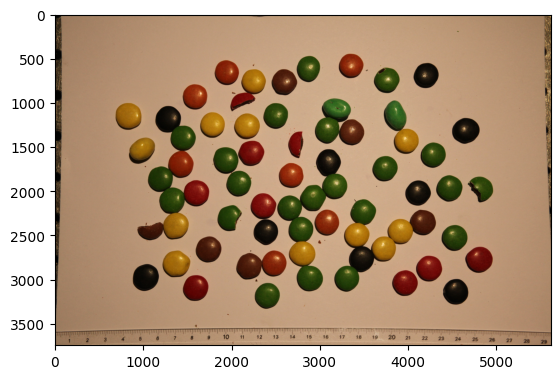

In [48]:
image = skimage.io.imread("IMG_2754_nonstop_alltogether.JPG")
plt.imshow(image);

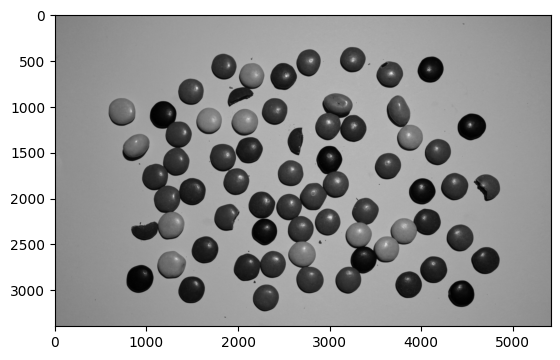

In [55]:
crop_top = 100
crop_bottom = -250
crop_left = 100
crop_right = -100

image_cropped = image[crop_top:crop_bottom, crop_left:crop_right]

# Convert the image to grayscale
gray_image = skimage.color.rgb2gray(image_cropped)

# Reduce the noise in the image with gaussian filter
blurred_image = skimage.filters.gaussian(gray_image, sigma=1)

# Display the processed images
plt.imshow(blurred_image, cmap="gray");

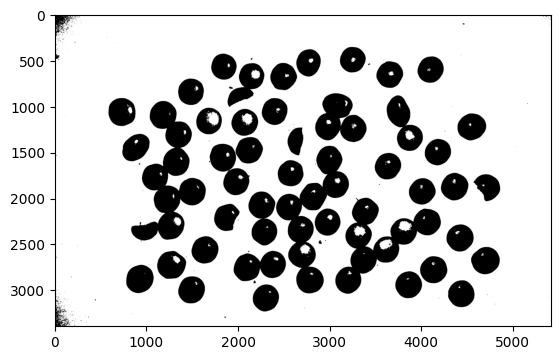

In [56]:
threshold_value = filters.threshold_otsu(blurred_image)

adjusted_threshold = threshold_value * 1.3
binary_image = blurred_image > adjusted_threshold

plt.imshow(binary_image, cmap="gray")

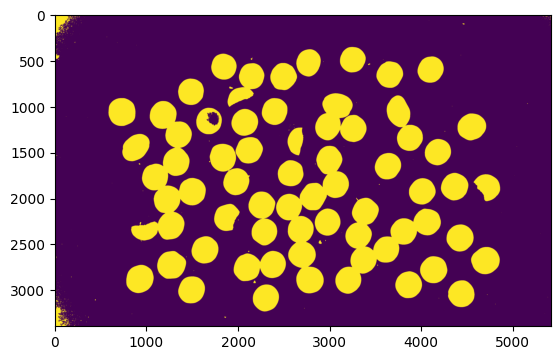

In [51]:
# Close and open shapes to remove noise
closed_image = area_closing(binary_image, 12000)
opened_image = area_opening(binary_image, 12000)
inverted_image = np.logical_not(opened_image)

plt.imshow(inverted_image, cmap="gray")

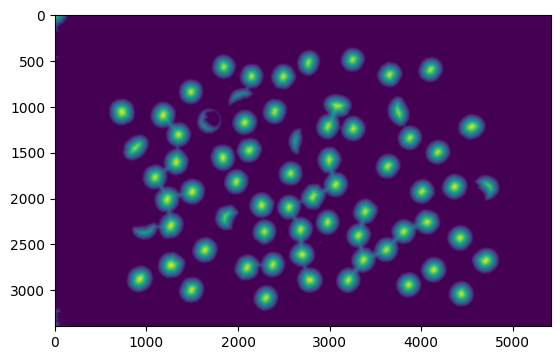

In [52]:
distance_image = ndi.distance_transform_edt(inverted_image)
plt.imshow(distance_image)


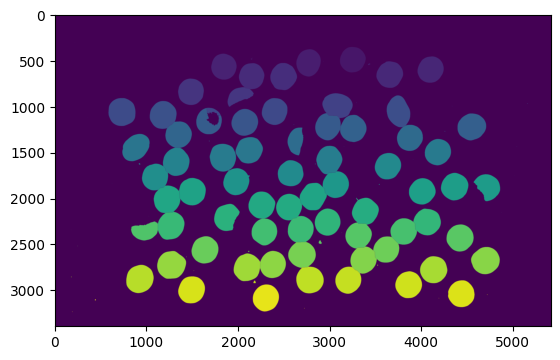

In [53]:
local_maximum = feature.peak_local_max(
    distance_image,
    footprint=np.ones((30,30)),
    labels=inverted_image.astype(int),
    min_distance=150
)

local_max_mask = np.zeros_like(distance_image, dtype=bool)
local_max_mask[tuple(local_maximum.T)] = True
markers, _ = ndi.label(local_max_mask)

labels = segmentation.watershed(-distance_image, markers, mask = inverted_image, watershed_line=True)

plt.imshow(labels)

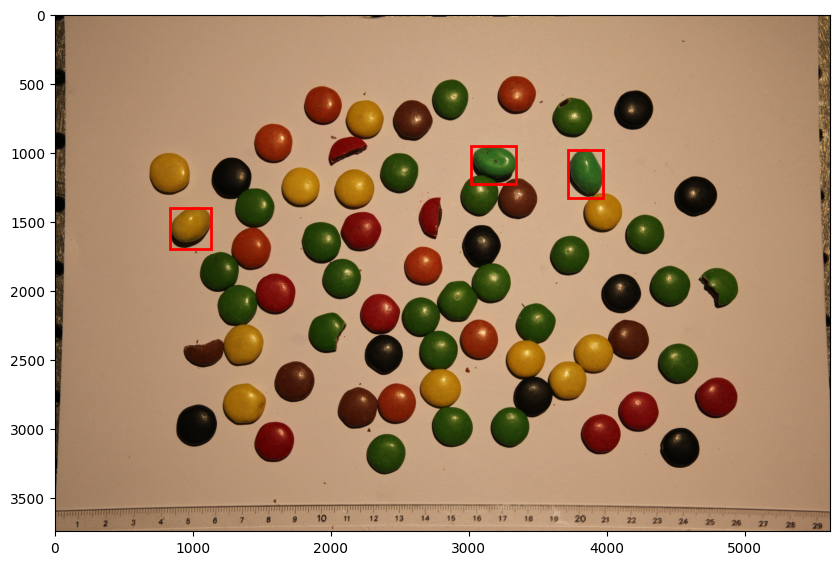

In [54]:
chocolates = measure.regionprops(labels)

mnms = [
    chocolate
    for chocolate in chocolates
    if chocolate.eccentricity >= 0.3
    and chocolate.eccentricity <= 0.75
    and chocolate.major_axis_length >= 330
    and chocolate.major_axis_length <= 350
]


fig, ax = plt.subplots(figsize=(10,7))
ax.imshow(image)

for mnm in mnms:
    y0, x0 = mnm.centroid
    eccentricity = mnm.eccentricity
    major_axis_length = mnm.major_axis_length

    minr, minc, maxr, maxc = mnm.bbox
    rect = plt.Rectangle(
        (minc + crop_left, minr + crop_top),
        maxc - minc,
        maxr - minr,
        fill=False,
        edgecolor = "red",
        linewidth=2,
    )
    ax.add_patch(rect)

plt.show()